In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.6 MB/s eta 0:00:00


In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

In [4]:
def create_dataset(dataset, look_back=7):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 7
future_dates = pd.date_range(start='2024-11-05', periods=3, freq='D')

In [5]:
def build_model(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)

    model.add(LSTM(hp_units, input_shape=(look_back, 1),
                   dropout=hp_dropout, recurrent_dropout=hp_dropout))
    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mape'])

    return model

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Harris 모델링 및 예측

In [7]:
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_harris.json', 'r') as f:
    harris_data = json.load(f)
harris_df = pd.DataFrame(list(harris_data.items()), columns=['date', 'score'])
harris_df['date'] = pd.to_datetime(harris_df['date'])
harris_df.set_index('date', inplace=True)
harris_df.sort_index(inplace=True)

In [8]:
harris_values = harris_df[['score']].values
scaler_h = MinMaxScaler((0,1))
scaled_h = scaler_h.fit_transform(harris_values)

In [9]:
X_h, y_h = create_dataset(scaled_h, look_back)
train_size_h = int(len(X_h)*0.95)
X_h_train, X_h_val = X_h[:train_size_h], X_h[train_size_h:]
y_h_train, y_h_val = y_h[:train_size_h], y_h[train_size_h:]
X_h_train = X_h_train.reshape((X_h_train.shape[0], X_h_train.shape[1], 1))
X_h_val = X_h_val.reshape((X_h_val.shape[0], X_h_val.shape[1], 1))

In [10]:
tuner_harris = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='harris_tuning_single_LSTM'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
tuner_harris.search(X_h_train, y_h_train,
                    validation_data=(X_h_val, y_h_val),
                    callbacks=[early_stop],
                    verbose=1)

Trial 30 Complete [00h 00m 05s]
val_loss: 0.050093937665224075

Best val_loss So Far: 0.004048545844852924
Total elapsed time: 00h 02m 00s


In [12]:
best_hps_h = tuner_harris.get_best_hyperparameters(num_trials=1)[0]
model_harris = tuner_harris.hypermodel.build(best_hps_h)

model_checkpoint_h = ModelCheckpoint('best_model_harris.keras', monitor='val_loss', save_best_only=True)

history_h = model_harris.fit(X_h_train, y_h_train,
                             validation_data=(X_h_val, y_h_val),
                             epochs=50,
                             batch_size=16,
                             callbacks=[early_stop, model_checkpoint_h],
                             verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.2046 - mape: 916290.6875 - val_loss: 0.1588 - val_mape: 61.8047
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1008 - mape: 490570.1562 - val_loss: 0.0339 - val_mape: 26.5664
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0472 - mape: 848875.9375 - val_loss: 0.0041 - val_mape: 9.3319
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0603 - mape: 3184249.0000 - val_loss: 0.0052 - val_mape: 8.0399
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0488 - mape: 14763195.0000 - val_loss: 0.0248 - val_mape: 21.8730
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0543 - mape: 2340860.7500 - val_loss: 0.0322 - val_mape: 25.6904
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0448 - mape: 2358228.0000 - val_loss: 0.0275 - val_mape: 23.3174
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0398 - mape: 1593557.2500 - val_loss: 0.0224 - val_mape: 20.5035


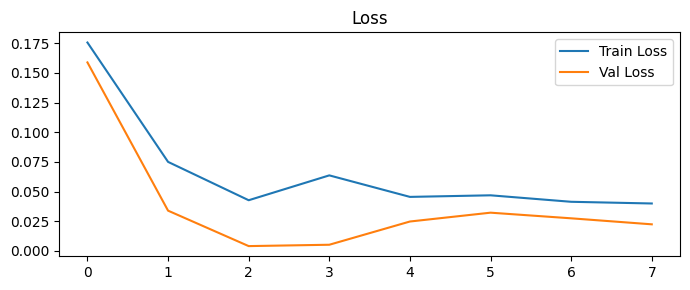

[0.17560315132141113, 0.07502561807632446, 0.042708903551101685, 0.06365720182657242, 0.04552314430475235, 0.04685566574335098, 0.04139682278037071, 0.03996980935335159]


In [13]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history_h.history['loss'], label='Train Loss')
ax.plot(history_h.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history_h.history['loss'])

In [14]:
best_model_harris = tf.keras.models.load_model('best_model_harris.keras')

In [15]:
# Harris 예측
last_sequence_h = scaled_h[-look_back:]
current_input_h = last_sequence_h.reshape((1, look_back, 1))
predictions_h = []
for i in range(3):
    pred_h = best_model_harris.predict(current_input_h, verbose=0)
    predictions_h.append(pred_h[0,0])
    current_input_h = np.append(current_input_h[:,1:,:], [[[pred_h[0,0]]]], axis=1)

In [16]:
predictions_h = scaler_h.inverse_transform(np.array(predictions_h).reshape(-1,1))
prediction_df_harris = pd.DataFrame(predictions_h, index=future_dates, columns=['predicted_score'])

## Trump 모델링 및 예측

In [17]:
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_trump.json', 'r') as f:
    trump_data = json.load(f)
trump_df = pd.DataFrame(list(trump_data.items()), columns=['date', 'score'])
trump_df['date'] = pd.to_datetime(trump_df['date'])
trump_df.set_index('date', inplace=True)
trump_df.sort_index(inplace=True)

In [18]:
trump_values = trump_df[['score']].values
scaler_t = MinMaxScaler((0,1))
scaled_t = scaler_t.fit_transform(trump_values)

In [19]:
X_t, y_t = create_dataset(scaled_t, look_back)
train_size_t = int(len(X_t)*0.95)
X_t_train, X_t_val = X_t[:train_size_t], X_t[train_size_t:]
y_t_train, y_t_val = y_t[:train_size_t], y_t[train_size_t:]
X_t_train = X_t_train.reshape((X_t_train.shape[0], X_t_train.shape[1], 1))
X_t_val = X_t_val.reshape((X_t_val.shape[0], X_t_val.shape[1], 1))

In [20]:
tuner_trump = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='trump_tuning_single_LSTM'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
tuner_trump.search(X_t_train, y_t_train,
                   validation_data=(X_t_val, y_t_val),
                   callbacks=[early_stop],
                   verbose=1)

Trial 30 Complete [00h 00m 04s]
val_loss: 0.042254455387592316

Best val_loss So Far: 0.010172618553042412
Total elapsed time: 00h 01m 57s


In [22]:
best_hps_t = tuner_trump.get_best_hyperparameters(num_trials=1)[0]
model_trump = tuner_trump.hypermodel.build(best_hps_t)

model_checkpoint_t = ModelCheckpoint('best_model_trump.keras', monitor='val_loss', save_best_only=True)

history_t = model_trump.fit(X_t_train, y_t_train,
                            validation_data=(X_t_val, y_t_val),
                            epochs=50,
                            batch_size=16,
                            callbacks=[early_stop, model_checkpoint_t],
                            verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1984 - mape: 321552.0938 - val_loss: 0.1609 - val_mape: 54.9360
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0470 - mape: 1243138.2500 - val_loss: 0.0098 - val_mape: 11.9598
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0429 - mape: 1223225.1250 - val_loss: 0.0194 - val_mape: 16.0506
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0413 - mape: 8891019.0000 - val_loss: 0.0784 - val_mape: 36.6898
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0373 - mape: 792030.5000 - val_loss: 0.0813 - val_mape: 37.4563


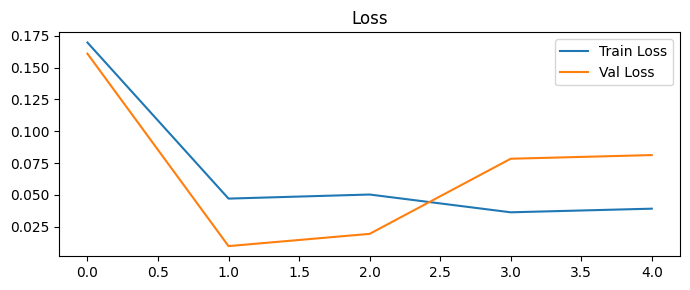

[0.16970056295394897, 0.04713645577430725, 0.050341393798589706, 0.0363793782889843, 0.03922782838344574]


In [30]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history_t.history['loss'], label='Train Loss')
ax.plot(history_t.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history_t.history['loss'])

In [24]:
best_model_trump = tf.keras.models.load_model('best_model_trump.keras')

In [25]:
# Trump 예측
last_sequence_t = scaled_t[-look_back:]
current_input_t = last_sequence_t.reshape((1, look_back, 1))
predictions_t = []
for i in range(3):
    pred_t = best_model_trump.predict(current_input_t, verbose=0)
    predictions_t.append(pred_t[0,0])
    current_input_t = np.append(current_input_t[:,1:,:], [[[pred_t[0,0]]]], axis=1)

In [26]:
predictions_t = scaler_t.inverse_transform(np.array(predictions_t).reshape(-1,1))
prediction_df_trump = pd.DataFrame(predictions_t, index=future_dates, columns=['predicted_score'])

## 시각화

In [36]:
print(harris_df)
print(prediction_df_harris)

               score
date                
2024-07-25  0.353315
2024-07-26  0.338160
2024-07-27  0.293853
2024-07-28  0.224996
2024-07-29  0.234419
...              ...
2024-10-31  0.250618
2024-11-01  0.329888
2024-11-02  0.308602
2024-11-03  0.252376
2024-11-04  0.272945

[103 rows x 1 columns]
            predicted_score
2024-11-05         0.294909
2024-11-06         0.308877
2024-11-07         0.309876


In [37]:
print(trump_df.index)
print(prediction_df_trump)

DatetimeIndex(['2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30',
               ...
               '2024-10-26', '2024-10-27', '2024-10-28', '2024-10-29',
               '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-02',
               '2024-11-03', '2024-11-04'],
              dtype='datetime64[ns]', name='date', length=107, freq=None)
            predicted_score
2024-11-05         0.289536
2024-11-06         0.324519
2024-11-07         0.334220


In [32]:
# 과거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기
harris_11_05 = pd.DataFrame({'score': [prediction_df_harris.loc['2024-11-05', 'predicted_score']]},
                             index=pd.to_datetime(['2024-11-05']))
trump_11_05 = pd.DataFrame({'score': [prediction_df_trump.loc['2024-11-05', 'predicted_score']]},
                            index=pd.to_datetime(['2024-11-05']))

harris_df_extended = pd.concat([harris_df, harris_11_05, prediction_df_harris], axis=0)
trump_df_extended = pd.concat([trump_df, trump_11_05, prediction_df_trump], axis=0)

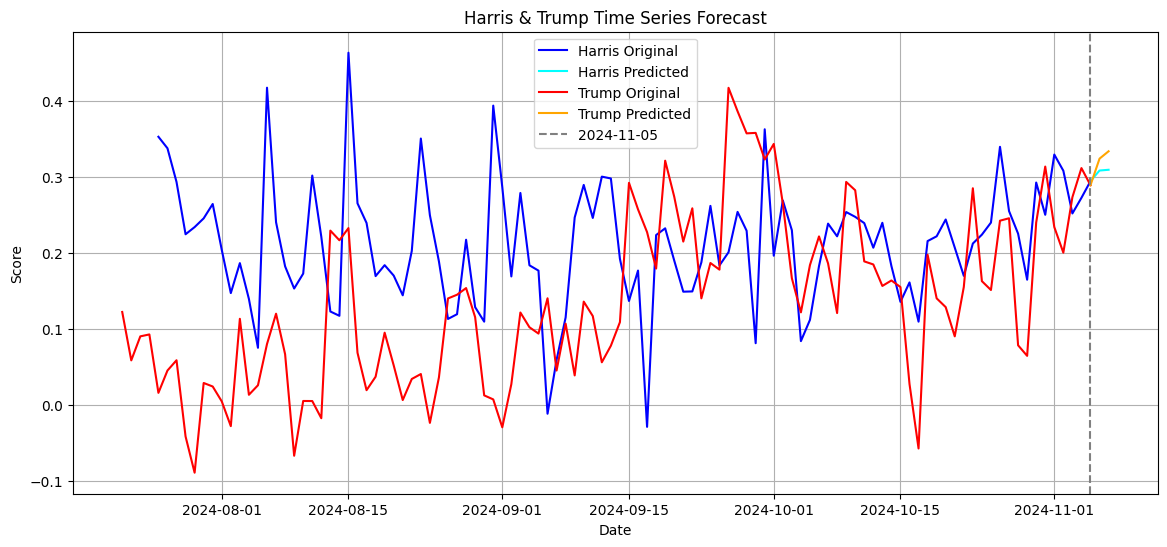

In [50]:
# Plot the extended data
plt.figure(figsize=(14, 6))

# Plot for Harris
plt.plot(harris_df_extended.index, harris_df_extended['score'], label='Harris Original', color='blue')
plt.plot(prediction_df_harris.index, prediction_df_harris['predicted_score'], label='Harris Predicted', color='cyan')

# Plot for Trump
plt.plot(trump_df_extended.index, trump_df_extended['score'], label='Trump Original', color='red')
plt.plot(prediction_df_trump.index, prediction_df_trump['predicted_score'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [46]:
# Filter the data for the specific date range (2024-11-02 to 2024-11-07)
date_range = pd.date_range(start='2024-11-02', end='2024-11-05')
pred_date_range = pd.date_range(start='2024-11-05', end='2024-11-07')

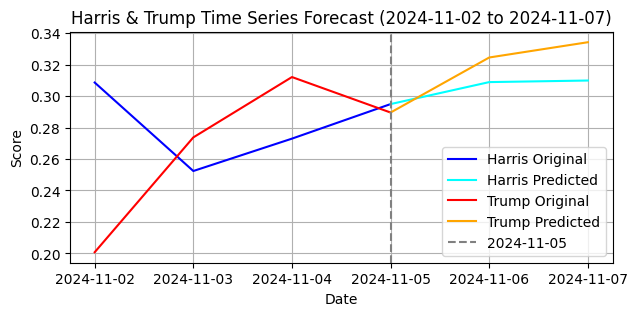

In [51]:
# Plot the extended data for the specified date range
plt.figure(figsize=(7, 3))

# Plot for Harris within the date range
harris_range = harris_df_extended.loc[date_range]
plt.plot(harris_range.index, harris_range['score'], label='Harris Original', color='blue')
harris_pred_range = prediction_df_harris.loc[pred_date_range]
plt.plot(harris_pred_range.index, harris_pred_range['predicted_score'], label='Harris Predicted', color='cyan')

# Plot for Trump within the date range
trump_range = trump_df_extended.loc[date_range]
plt.plot(trump_range.index, trump_range['score'], label='Trump Original', color='red')
trump_pred_range = prediction_df_trump.loc[pred_date_range]
plt.plot(trump_pred_range.index, trump_pred_range['predicted_score'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast (2024-11-02 to 2024-11-07)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()